# Application of QCL to Machine Learning

3.4節で学んだ **Quantum Circuit Learning** (量子回路学習、QCL)は機械学習への応用を念頭に設計された量子アルゴリズムである。  
3.4節では入出力ともに1次元の関数を扱ったが、現実の機械学習に応用するためには、より複雑な関数を近似できることが必要である。  

ここではQCLの機械学習への応用例として、代表的な機械学習のデータセットの一つである[**Irisデータセット**](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)（Fisherのあやめ）の分類を行う。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## データの概要

irisデータセットは機械学習でよく使われるアヤメの品種データである。  
花びらやがくの長さ・幅のデータから、3品種のうちどれに属するかを分類する。  
より詳細には[こちらのサイト](https://note.nkmk.me/python-scikit-learn-svm-iris-dataset/)を参照されたい。

まず、scikit-learnから、Irisデータセットを読み込む。  

In [2]:
# Irisデータセットの読み込み

import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()

# 扱いやすいよう、pandasのDataFrame形式に変換
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['target_names'] = iris.target_names[iris.target]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


ここで、列名の最初の4つ（sepal lengthなど）は、「がく」や花びらの長さ・幅を表しており、target, target_namesはそれぞれ品種番号(0,1,2)、品種名を表している。

In [3]:
# サンプル総数
print(f"# of records: {len(df)}\n")

# 各品種のサンプル数
print("value_counts:")
print(df.target_names.value_counts())

# of records: 150

value_counts:
virginica     50
versicolor    50
setosa        50
Name: target_names, dtype: int64


各サンプルについて、sepal length（がくの長さ）など4種類のデータがあるが、これらのうちpetal length(花びらの長さ), petal width(花びらの幅)に着目して分析を行う。

In [4]:
## 教師データ作成
# ここではpetal length, petal widthの2種類のデータを用いる。より高次元への拡張は容易である。
x_train = df.loc[:,['petal length (cm)', 'petal width (cm)']].to_numpy() # shape:(150, 2)
y_train = np.eye(3)[iris.target] # one-hot 表現 shape:(150, 3)

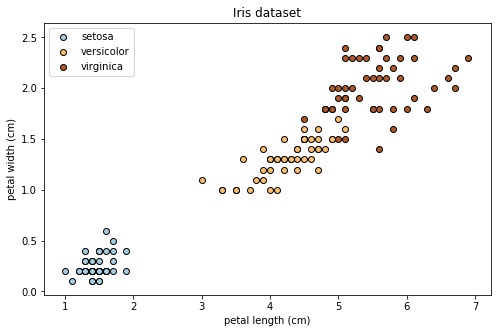

In [5]:
# データ点のプロット
plt.figure(figsize=(8, 5))

for t in range(3):
    x = x_train[iris.target==t][:,0]
    y = x_train[iris.target==t][:,1]
    cm = [plt.cm.Paired([c]) for c in [0,6,11]]
    plt.scatter(x, y, c=cm[t], edgecolors='k', label=iris.target_names[t])

# label
plt.title('Iris dataset')
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)') 
plt.legend()
plt.show()

## QCLを用いた分類

以下ではQCLを用いた分類問題を解くクラスであるQclClassificationを用いて、実際にIrisデータセットが分類される様子を見る。

In [6]:
from qcl_classification import QclClassification

In [7]:
# 乱数発生器の初期化（量子回路のパラメータの初期値に用いる）
random_seed = 0
np.random.seed(random_seed)

In [8]:
# 量子回路のパラメータ
nqubit = 3 ## qubitの数。必要とする出力の次元数よりも多い必要がある
c_depth = 2 ## circuitの深さ
num_class = 3 ## 分類数（ここでは3つの品種に分類）

In [9]:
# QclClassificationクラスをインスタンス化
qcl = QclClassification(nqubit, c_depth, num_class)

QclClassificationのfit()メソッドで、関数のfittingを行う。  
学習には筆者のPCで1分程度を要する。

In [10]:
%%time
# 学習を行う
# ここではNelder-Mead法を用いる
res, theta_init, theta_opt = qcl.fit(x_train, y_train, maxiter=1000)

Initial parameter:
[2.74944154 5.60317502 6.0548717  2.40923412 4.97455513 3.32314479
 3.56912924 5.8156952  0.44633272 0.54744954 0.12703594 5.23150478
 4.88930306 5.46644755 6.14884039 5.02126135 2.89956035 4.90420945]

Initial value of cost function:  0.9218

Iteration count...
Iteration: 100 / 1000,   Value of cost_func: 0.7567
Iteration: 200 / 1000,   Value of cost_func: 0.7358
Iteration: 300 / 1000,   Value of cost_func: 0.7157
Iteration: 400 / 1000,   Value of cost_func: 0.7111
Iteration: 500 / 1000,   Value of cost_func: 0.6886
Iteration: 600 / 1000,   Value of cost_func: 0.6809
Iteration: 700 / 1000,   Value of cost_func: 0.6803
Iteration: 800 / 1000,   Value of cost_func: 0.6802
Iteration: 900 / 1000,   Value of cost_func: 0.6802

Optimized parameter:
[2.01293141e+00 4.85442551e+00 3.34321975e+00 3.95871935e+00
 2.59723630e+00 3.80915883e+00 2.10212523e+00 5.55684541e+00
 4.46151079e-03 5.20983610e-01 1.48202747e-01 8.47734542e+00
 4.16801769e+00 7.19207499e+00 7.36634981e+00

## プロット

In [11]:
# グラフ用の設定
h = .05  # step size in the mesh
X = x_train
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [12]:
# 各petal length, petal widthについて、モデルの予測値をプロットする関数
def decision_boundary(X, y, theta, title='(title here)'):
    plt.figure(figsize=(8, 5))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    qcl.set_input_state(np.c_[xx.ravel(), yy.ravel()])
    Z = qcl.pred(theta) # モデルのパラメータθも更新される
    Z = np.argmax(Z, axis=1)
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)

    # label
    plt.title(title)
    plt.xlabel('petal length (cm)')
    plt.ylabel('petal width (cm)')
    plt.show()

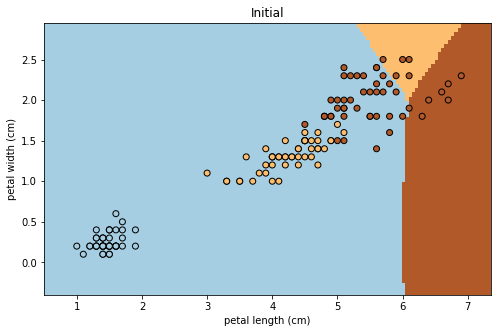

In [13]:
# パラメータthetaの初期値のもとでのグラフ
decision_boundary(x_train, iris.target, theta_init, title='Initial')

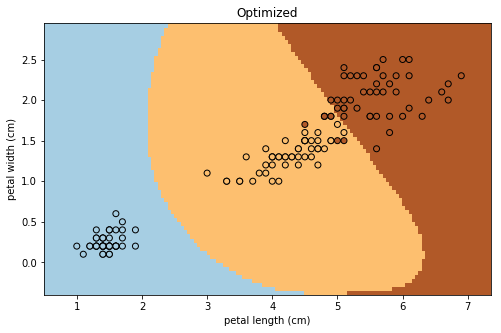

In [14]:
# パラメータthetaの最適解のもとでのグラフ
decision_boundary(x_train, iris.target, theta_opt, title='Optimized')

上図、下図がそれぞれ学習前、学習後に対応している。ここで、データ点と各メッシュの色は、それぞれ同じ品種に対応している。  
確かにIrisデータセットの分類に成功していることがわかる。

## まとめ

本節では、量子回路学習(QCL)を用いて実際の機械学習の問題（分類問題）の解決を行った。  
以上は簡単な例ではあるが、量子コンピュータの機械学習への応用の可能性を示唆している。  
意欲のある読者は、QCLを用いてより高度な機械学習のタスク（画像認識、自然言語処理など）や、上記モデルの改善に挑戦されたい。  
また、更に深く勉強されたい向きは、QunaSys CTO 御手洗による、量子機械学習に関する[講義ノート](https://www2.yukawa.kyoto-u.ac.jp/~qischool2019/mitaraiCTO.pdf)を参照されたい。